# Olfactory Bulb Interfrequency Transfer Entropy

In this preliminary analysis we will use *transfer entropy* to look at the information flow between various frequency bands from an olfactory bulb recording.

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'image.cmap': 'jet'},style="whitegrid")

# Add python dir to path
import sys
sys.path.append('python/')

import networkx as nx
from nxpd import nxpdParams, draw
nxpdParams['show'] = 'ipynb'


## Data Collection

5253


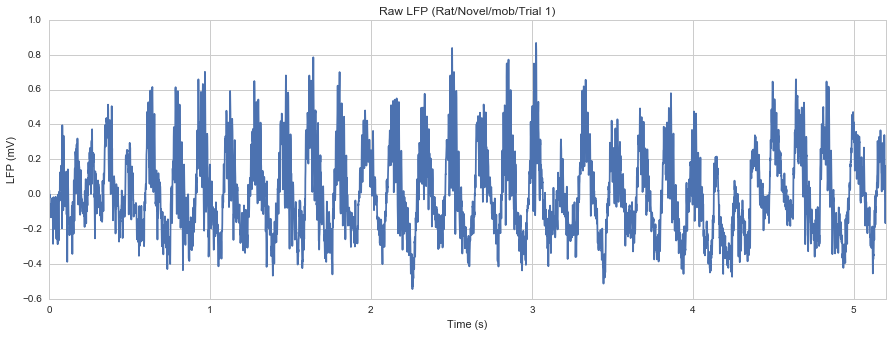

In [2]:
data = sio.loadmat('data/Rat_170315.mat')['data']

# {Rat, Robot, Object, Grooming, Baseline}
type1 = 'Rat'
# {Novel, Familiar}
type2 = 'Novel'
# {mob, ca2, amyg}
region = 'mob'
# {1,...,<num_trials>}
trial = 1

if type1 in ('Rat','Robot','Object'):
    signal = data[type1][0,0][type2][0,0][region][0,0][trial][0]
else:
    signal = data[type1][0,0][region][0,0][trial][0]
    
# Define sample rate (Hz)
fs = 1010.10 
# Total number of samples
N = signal.size
# Time indices of samples
ns = np.linspace(0,N/fs,N)
# Reshape signal to be 1-D vector
signal = signal.reshape(N)

fig = plt.figure(figsize=(15,5))
plt.plot(ns,signal)
plt.title("Raw LFP (%s/%s/%s/Trial %i)"%(type1,type2,region,trial))
plt.xlabel('Time (s)')
plt.ylabel('LFP (mV)')
plt.xlim([0,N/fs]);
print(N)


## Extraction of Frequency Bands

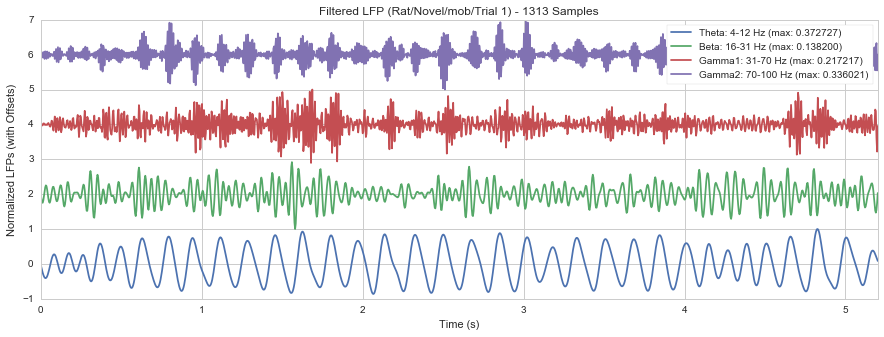

In [3]:
# Filtering function from supplementary python file
from preprocess import extract_freqs

# Define frequency bands in Hz (copied from Eric's ppt)
theta_band = [4.0,12.0]
beta_band = [16.0,31.0]
gamma_band1_low = [31.0,59.0] # Below 60 Hz Noise
gamma_band1_high = [61.0,70] # Above 60 Hz noise
gamma_band2 = [70.0,100.0]


# Decimate so that the model is simpler (dec_factor=1 leaves the same)
dec_factor = 4

# Filter for each band and normalize
[theta,beta,gamma2],[max_theta,max_beta,max_gamma2] = \
    extract_freqs(signal,[theta_band,beta_band,gamma_band2],fs,normalize=True,dec=dec_factor)
    
# Filter the 31-70Hz band without normalizing
[gamma1_low,gamma1_high],[_,_] = extract_freqs(signal,[gamma_band1_low,gamma_band1_high],fs,normalize=False,dec=dec_factor)
# Combine the below and above 60 Hz noise components of 31 - 70 Hz Gamma Band
gamma1 = gamma1_low + gamma1_high
# Normalize
max_gamma1 = np.amax(gamma1)
gamma1 = gamma1/max_gamma1

# Recreate time indices with correct number of points
ns = np.linspace(0,N/fs,len(theta))
    
fig = plt.figure(figsize=(15,5))
plt.plot(ns,theta,label='Theta: %d-%d Hz (max: %f)'%(theta_band[0],theta_band[1],max_theta))
plt.plot(ns,beta+2,label='Beta: %d-%d Hz (max: %f)'%(beta_band[0],beta_band[1],max_beta))
plt.plot(ns,gamma1+4,label='Gamma1: %d-%d Hz (max: %f)'%(gamma_band1_low[0],gamma_band1_high[1],max_gamma1))
plt.plot(ns,gamma2+6,label='Gamma2: %d-%d Hz (max: %f)'%(gamma_band2[0],gamma_band2[1],max_gamma2))
plt.title("Filtered LFP (%s/%s/%s/Trial %i) - %i Samples"%(type1,type2,region,trial,N/dec_factor))
plt.xlabel('Time (s)')
plt.ylabel('Normalized LFPs (with Offsets)')
plt.xlim([0,N/fs])
plt.legend(frameon=True);


## Estimation of Information Flow

Now that we have our signals of interest, we can look at the information flow between them. For starters we will look at the pairwise ***transfer entropy*** (TE) using the Java Information Dynamics Toolkit ([JIDT](https://github.com/jlizier/jidt)).

We will start by assigning 2 of the 3 signals of interest to time series given by $x_n$ and $y_n$ for $n=1,\dots,N$, where $N$ is the total number of samples. We can think of these as *realizations of random processes* $X^N$ (with $X^N = X_1,\dots,X_N$) and $Y^N$ that obey some joint distribution $P_{X^n,Y^n}(x^n,y^n)$. Once we have this distribution, we can compute the TE (from $X$ to $Y$) as:

$$
T_{X \rightarrow Y}(k,l,\tau) = I(Y_{n+1} ; X_{n-\tau-l}^{n-\tau} \mid Y_{n-k}^n)
$$

Where $I$ represents the ***mutual information*** (MI). Thus, we can think of the TE as the amount of information shared by the past $l$ samples of $X$ (with a lag of $\tau$) and the next sample of $Y$ *given* the past $k$ samples of $Y$. Using the definition of MI we can equivalently define TE using ***conditional entropies***:

$$
T_{X \rightarrow Y}(k,l,\tau) = \underbrace{H(Y_{n+1} \mid Y_{n-k}^n)}_{A} - \underbrace{H(Y_{n+1} \mid Y_{n-k}^n , X_{n-\tau-l}^{n-\tau})}_{B}
$$

which yields the following intuition - we start with the uncertainty in the next sample of $Y$ given its own past ($A$), then we subtract the uncertainty in the next sample of $Y$ given its own past *and* the past of $X$ ($B$). Thus, when the past of $X$ tells us nothing about the future of $Y$ that the past of $Y$ doesn't tell us, well get $A=B$ and the TE is zero. On the other hand, in the extreme case where the past of $X$ resolves all the uncertainty that remains in the future of $Y$, we would get $B=0$ and the TE is equal to $A$.

We note that from the properties of entropy, we have $A \ge 0$, $B \ge 0$, and $B \le A$. Thus we get:

$$
H(Y_{n+1} \mid Y_{n-k}^n) \ge T_{X \rightarrow Y}(k,l,\tau) \ge 0
$$

Below we compute and visualize the TE results on the filtered OB data above. Note that the values for $k,l,$ and $\tau$ are optimized and automatically selected by JIDT.

In [4]:
from information_flow import compute_te

te = []

for (X,Y,nodes) in [(theta,beta,(0,1)),
                    (theta,gamma1,(0,2)),
                    (theta,gamma2,(0,3)),
                    (beta,gamma1,(1,2)),
                    (beta,gamma2,(1,3)),
                    (gamma1,gamma2,(2,3))]:

    teXToY, teYToX = compute_te(X,Y,knns=[8])
    te.append((nodes[0],nodes[1],teXToY[0]))
    te.append((nodes[1],nodes[0],teYToX[0]))

TypeError: Package infodynamics.measures.continuous.kraskov.TransferEntropyCalculatorKraskov is not Callable

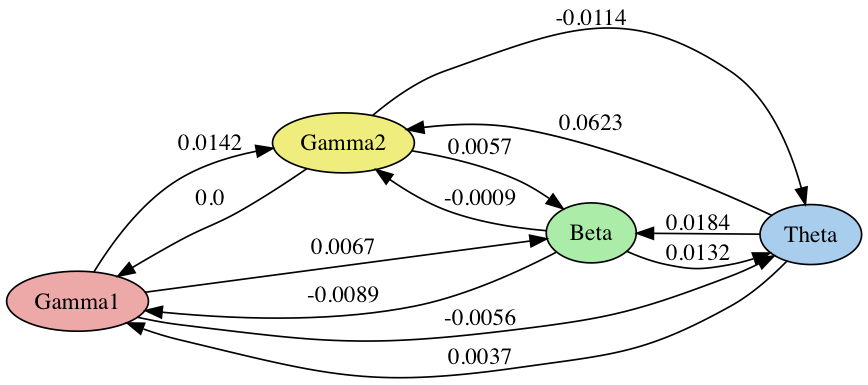

In [5]:
from information_flow import graph_te

labels = ('Theta','Beta','Gamma1','Gamma2')
colors = {'Theta':'#a8cded','Beta':'#abeda8','Gamma1':'#eda8a8','Gamma2':'#eeed7e'}
dir_graph = graph_te(te,labels,colors)
draw(dir_graph)

Next we average the transfer entropies across trials of the same type. 

Processing Rat/Novel Trials
Processing Rat/Familiar Trials
Processing Robot/Novel Trials
Processing Robot/Familiar Trials


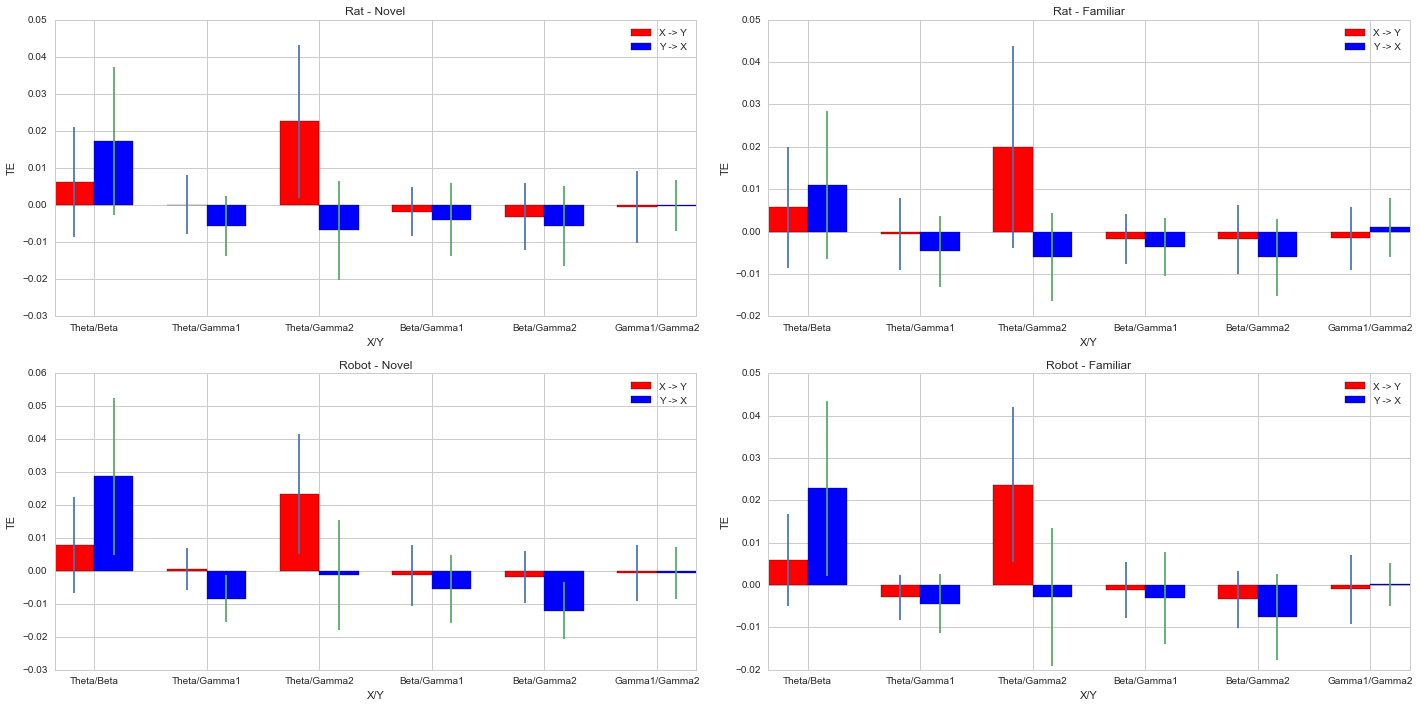

In [9]:
data = sio.loadmat('data/Rat_170315.mat')['data']

fs = 1010.10 
dec_factor = 4
region = 'mob'
theta_band = [4.0,12.0]
beta_band = [16.0,31.0]
gamma_band1_low = [31.0,59.0] # Below 60 Hz Noise
gamma_band1_high = [61.0,70] # Above 60 Hz noise
gamma_band2 = [70.0,100.0]

# {Rat, Robot, Object, Grooming, Baseline}
type1 = 'Rat'
# {Novel, Familiar}
type2 = 'Novel'
trial = 1

f, axarr = plt.subplots(2, 2)
f.set_size_inches(20, 10)

for i,type1 in enumerate(['Rat','Robot']):
    for j,type2 in enumerate(['Novel','Familiar']):
        print('Processing %s/%s Trials'%(type1,type2))
        ax = axarr[i,j]
        trials = data[type1][0,0][type2][0,0][region][0,0]
        tes = np.zeros((12,len(trials)))
        for trial_num,trial in enumerate(trials[1:]):
            signal = trial[0]
            N = signal.size
            # Ensure signal is at least 1 sec long
            if N > fs:
                signal = signal.reshape(N)
                [theta,beta,gamma2],[max_theta,max_beta,max_gamma2] = \
                        extract_freqs(signal,[theta_band,beta_band,gamma_band2],fs,normalize=True,dec=dec_factor)
                [gamma1_low,gamma1_high],[_,_] = extract_freqs(signal,[gamma_band1_low,gamma_band1_high],fs,normalize=False,dec=dec_factor)
                gamma1 = gamma1_low + gamma1_high
                max_gamma1 = np.amax(gamma1)
                gamma1 = gamma1/max_gamma1
                
                for k,(X,Y) in enumerate([(theta,beta),
                                          (theta,gamma1),
                                          (theta,gamma2),
                                          (beta,gamma1),
                                          (beta,gamma2),
                                          (gamma1,gamma2)]):

                    teXToY, teYToX = compute_te(X,Y,knns=[8],status=False)
                    tes[k,trial_num] = teXToY[0]
                    tes[k+6,trial_num] = teYToX[0]
                
        # Remove zero columns
        tes = tes[~np.all(tes == 0,axis=1)]
        ind = np.arange(6)  # the x locations for the groups
        width = 0.35  
        rects1 = ax.bar(ind, np.mean(tes[0:6,:],axis=1), width, color='r', yerr=np.std(tes[0:6,:],axis=1))
        rects2 = ax.bar(ind + width, np.mean(tes[6:,:],axis=1), width, color='b', yerr=np.std(tes[6:,:],axis=1))
        ax.legend((rects1[0], rects2[0]), ('X -> Y', 'Y -> X'))
        ax.set_ylabel('TE')
        ax.set_xlabel('X/Y')
        ax.set_title('%s - %s'%(type1,type2))
        ax.set_xticks(ind + width)
        ax.set_xticklabels(('Theta/Beta', 'Theta/Gamma1', 'Theta/Gamma2',
                            'Beta/Gamma1', 'Beta/Gamma2', 'Gamma1/Gamma2',))
        ax.set_xlim([ind[0],ind[-1]+2*width])
f.tight_layout()

Processing Grooming Trials
Processing Baseline Trials


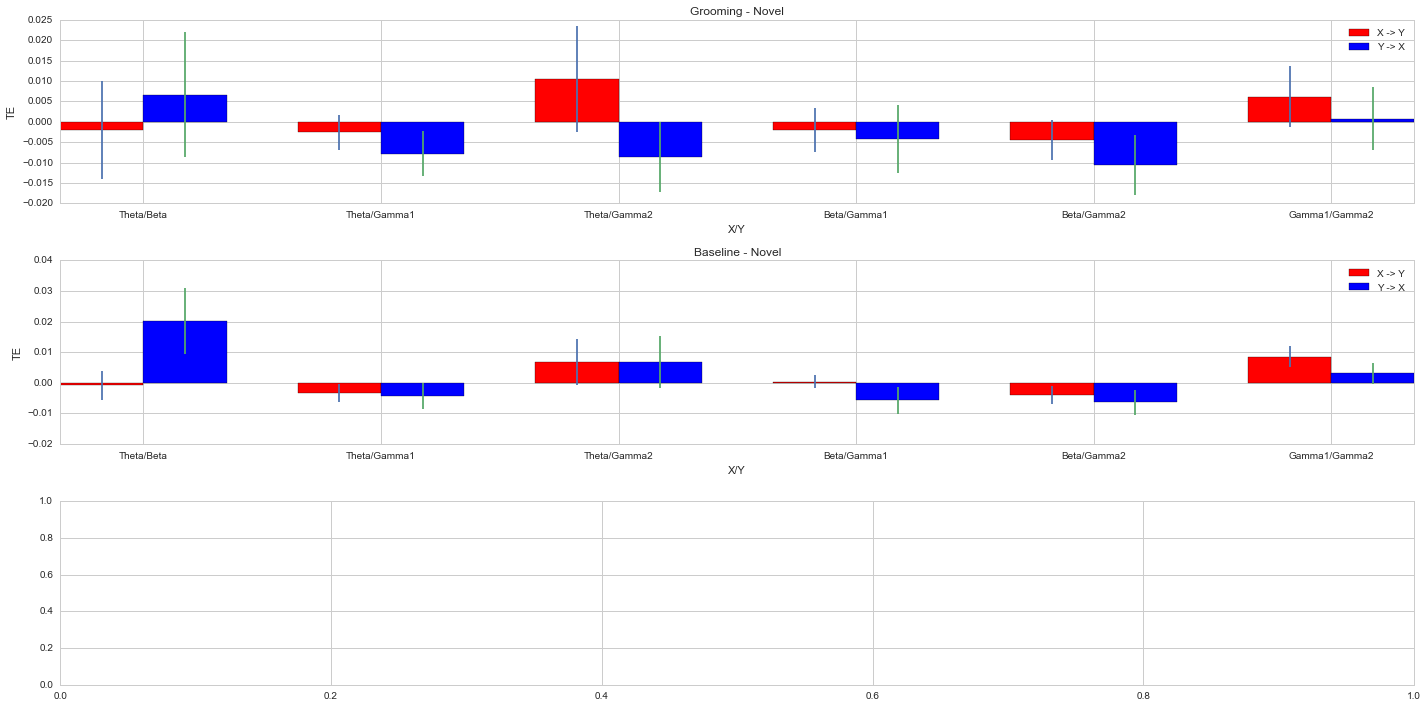

In [14]:
data = sio.loadmat('data/Rat_170315.mat')['data']

fs = 1010.10 
dec_factor = 4
region = 'mob'
theta_band = [4.0,12.0]
beta_band = [16.0,31.0]
gamma_band1_low = [31.0,59.0] # Below 60 Hz Noise
gamma_band1_high = [61.0,70] # Above 60 Hz noise
gamma_band2 = [70.0,100.0]

# {Rat, Robot, Object, Grooming, Baseline}
type1 = 'Rat'
# {Novel, Familiar}
type2 = 'Novel'
trial = 1

f, axarr = plt.subplots(2, 2)
f.set_size_inches(20, 10)

for i,type1 in enumerate(['Grooming','Baseline']):
    print('Processing %s Trials'%(type1))
    ax = axarr[i]
    trials = data[type1][0,0][region][0,0]
    tes = np.zeros((12,len(trials)))
    for trial_num,trial in enumerate(trials[1:]):
        signal = trial[0]
        N = signal.size
        # Ensure signal is at least 1 sec long
        if N > fs:
            signal = signal.reshape(N)
            [theta,beta,gamma2],[max_theta,max_beta,max_gamma2] = \
                    extract_freqs(signal,[theta_band,beta_band,gamma_band2],fs,normalize=True,dec=dec_factor)
            [gamma1_low,gamma1_high],[_,_] = extract_freqs(signal,[gamma_band1_low,gamma_band1_high],fs,normalize=False,dec=dec_factor)
            gamma1 = gamma1_low + gamma1_high
            max_gamma1 = np.amax(gamma1)
            gamma1 = gamma1/max_gamma1

            for k,(X,Y) in enumerate([(theta,beta),
                                      (theta,gamma1),
                                      (theta,gamma2),
                                      (beta,gamma1),
                                      (beta,gamma2),
                                      (gamma1,gamma2)]):

                teXToY, teYToX = compute_te(X,Y,knns=[8],status=False)
                tes[k,trial_num] = teXToY[0]
                tes[k+6,trial_num] = teYToX[0]

    # Remove zero columns
    tes = tes[~np.all(tes == 0,axis=1)]
    ind = np.arange(6)  # the x locations for the groups
    width = 0.35  
    rects1 = ax.bar(ind, np.mean(tes[0:6,:],axis=1), width, color='r', yerr=np.std(tes[0:6,:],axis=1))
    rects2 = ax.bar(ind + width, np.mean(tes[6:,:],axis=1), width, color='b', yerr=np.std(tes[6:,:],axis=1))
    ax.legend((rects1[0], rects2[0]), ('X -> Y', 'Y -> X'))
    ax.set_ylabel('TE')
    ax.set_xlabel('X/Y')
    ax.set_title('%s'%(type1))
    ax.set_xticks(ind + width)
    ax.set_xticklabels(('Theta/Beta', 'Theta/Gamma1', 'Theta/Gamma2',
                        'Beta/Gamma1', 'Beta/Gamma2', 'Gamma1/Gamma2',))
    ax.set_xlim([ind[0],ind[-1]+2*width])
f.tight_layout()

Some thoughts:

+ In the single trial example the transfer entropy from the theta band to gamma band is the largest value by a considerable amount, which is what we would expect. However, when we average across trials we see that this is not always the case. It will be important to look in to why there is such a large variance across trials.
+ Some of the estimates are negative. This is a result of the entropies (previously referred to as $A$ and $B$) being estimated separately so they don't necessarily need to obey the inequality $A \ge B$. The good news is that our approach will, by definition, always be non-negative.
+ The above approach assumes stationarity. In order to get time-varying estimates we would need to take a windowing approach, which would require running the algorithm on fewer samples. Given that some of the estimates are negative, it already calls into question the reliability of the estimates.
+ Lastly, we need to develop some means of testing the significance of these types of results. In this case, we can be somewhat satisfied because the results confirm what we *already believed*, though we will in the future want to be able to *learn* the flow of information in ways we didn't already know.